# PRACTICA 1 - Sandoval Chávez Héctor Jahir

In [12]:
import sys
sys.path.append('tsp')
import os
from os import path, listdir
from tsp import benchmarks,metrics,tspplot
from tsp.tspobject import TSPObject

benchmark_path = r'benchmarks'

In [14]:
import numpy as np
import random

def random_tour(O):
    names = O.V
    return list(np.random.permutation(names))

## Algoritmo Greedy

In [15]:
def TSP_greedy(O,start_index=0):
    nodes = O.V
    matrix = O._M
    n = len(nodes)
    tour = [nodes[start_index]]
    for i in range(n-1):
        available_nodes = list(set(nodes)-set(tour+[nodes[i]]))
        neighbors = {k:matrix[tour[-1]][k] for k in available_nodes}
        best = min(neighbors, key=neighbors.get)
        tour.append(best)
    return tour

## Algoritmo Best Greedy

In [16]:
def Best_TSP_greedy(O):
    _min_cost = np.inf
    _min_tour = None
    for start_index in range(len(O.V)):
        tour = TSP_greedy(O,start_index=start_index)
        cost = O.evaluate_tour(tour)
        if cost<_min_cost:
            _min_cost=cost
            _min_tour=tour
    return _min_tour

### Ejecución de Algoritmos Greedy y Best Greedy

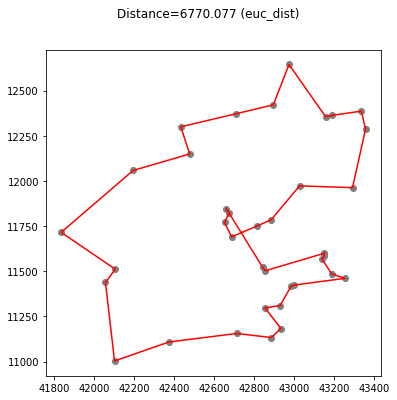

In [181]:
# Obtener Benchmark
test_file = path.join(benchmark_path,'dj38.tsp')

# Crear Objeto TSP
O = TSPObject(test_file,metrics.euc_dist)

# Crear Matriz de Distancias
O.M()


# Algoritmo Greedy con Indice Especifico
#tour = TSP_greedy(O,0)

# Algoritmo Greedy con Indice Aleatorio
#tour = TSP_greedy(O,np.random.randint(len(O.V)))

# Algoritmo Best Greedy
tour = Best_TSP_greedy(O)


# Graficar Tour
tspplot.plot_tsp(O,tour,figsize=(6,6))

## Algoritmo Christofides

In [18]:
def tsp_c(O):
    data = O.points
    
    # build a graph
    G = build_graph(data)

    # build a minimum spanning tree
    MSTree = minimum_spanning_tree(G)

    # find odd vertexes
    odd_vertexes = find_odd_vertexes(MSTree)

    # add minimum weight matching edges to MST
    minimum_weight_matching(MSTree, G, odd_vertexes)

    # find an eulerian tour
    eulerian_tour = find_eulerian_tour(MSTree, G)

    current = eulerian_tour[0]
    path = [str(current+1)]
    visited = [False] * len(eulerian_tour)
    visited[current] = True
    length = 0
    for v in eulerian_tour[1:]:
        if not visited[v]:
            path.append(str(v+1))
            visited[v] = True
            length += G[current][v]
            current = v
    return path


def get_length(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** (1 / 2)


def build_graph(data):
    graph = {}
    for this in range(len(data)):
        for another_point in range(len(data)):
            if this != another_point:
                if this not in graph:
                    graph[this] = {}
                graph[this][another_point] = get_length(data[this][0], data[this][1], data[another_point][0],
                                                        data[another_point][1])
    return graph


class UnionFind:
    def __init__(self):
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object
        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]
        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root

    def __iter__(self):
        return iter(self.parents)

    def union(self, *objects):
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r], r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest


def minimum_spanning_tree(G):
    tree = []
    subtrees = UnionFind()
    for W, u, v in sorted((G[u][v], u, v) for u in G for v in G[u]):
        if subtrees[u] != subtrees[v]:
            tree.append((u, v, W))
            subtrees.union(u, v)
    return tree


def find_odd_vertexes(MST):
    tmp_g = {}
    vertexes = []
    for edge in MST:
        if edge[0] not in tmp_g:
            tmp_g[edge[0]] = 0
        if edge[1] not in tmp_g:
            tmp_g[edge[1]] = 0
        tmp_g[edge[0]] += 1
        tmp_g[edge[1]] += 1
    for vertex in tmp_g:
        if tmp_g[vertex] % 2 == 1:
            vertexes.append(vertex)
    return vertexes


def minimum_weight_matching(MST, G, odd_vert):
    import random
    random.shuffle(odd_vert)
    while odd_vert:
        v = odd_vert.pop()
        length = float("inf")
        u = 1
        closest = 0
        for u in odd_vert:
            if v != u and G[v][u] < length:
                length = G[v][u]
                closest = u
        MST.append((v, closest, length))
        odd_vert.remove(closest)


def find_eulerian_tour(MatchedMSTree, G):
    # find neigbours
    neighbours = {}
    for edge in MatchedMSTree:
        if edge[0] not in neighbours:
            neighbours[edge[0]] = []
        if edge[1] not in neighbours:
            neighbours[edge[1]] = []
        neighbours[edge[0]].append(edge[1])
        neighbours[edge[1]].append(edge[0])

    # finds the hamiltonian circuit
    start_vertex = MatchedMSTree[0][0]
    EP = [neighbours[start_vertex][0]]
    while len(MatchedMSTree) > 0:
        for i, v in enumerate(EP):
            if len(neighbours[v]) > 0:
                break
        while len(neighbours[v]) > 0:
            w = neighbours[v][0]
            remove_edge_from_matchedMST(MatchedMSTree, v, w)
            del neighbours[v][(neighbours[v].index(w))]
            del neighbours[w][(neighbours[w].index(v))]
            i += 1
            EP.insert(i, w)
            v = w
    return EP


def remove_edge_from_matchedMST(MatchedMST, v1, v2):
    for i, item in enumerate(MatchedMST):
        if (item[0] == v2 and item[1] == v1) or (item[0] == v1 and item[1] == v2):
            del MatchedMST[i]
    return MatchedMST

### Ejecución de Algoritmo Christofides

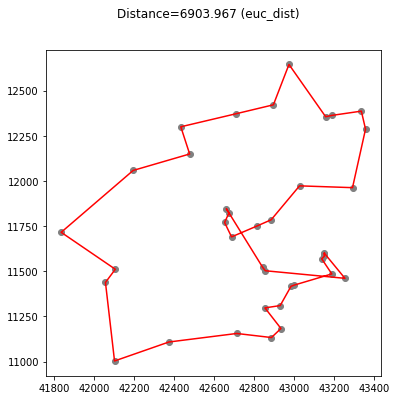

In [183]:
# Obtener Benchmark
test_file = path.join(benchmark_path,'dj38.tsp')

# Crear Objeto TSP
O = TSPObject(test_file,metrics.euc_dist)


# Algoritmo Christofides
_,tour = tsp_c(O.points)


# Graficar Tour
tspplot.plot_tsp(O,tour,figsize=(6,6))

### Algoritmo Hill Climbing

In [5]:
def hc_tsp(O,tour):
    actual = tour
    iteraciones = 1000
    v = 100
    valor_actual = O.evaluate_tour(actual)
    for i in range(iteraciones):
        vecinos = []
        valores = []
        for j in range(v):
            # Obtener vecino intercambiando dos ciudades
            nuevo = obtener_vecino(actual)
            # Obtener vecino intercambiando dos ciudades lejanas
            #nuevo = obtener_vecino_opt(actual,O._M)
            valor_nuevo = O.evaluate_tour(nuevo)
            vecinos.append(nuevo)
            valores.append(valor_nuevo)
        mejor = np.argmin(valores)
        if valores[mejor] < valor_actual:
            actual = vecinos[mejor]
            valor_actual = valores[mejor]
    return actual

def obtener_vecino(tour):
    vecino = tour[:]
    n1 = np.random.randint(len(vecino))
    n2 = np.random.randint(len(vecino))
    aux = vecino[n1]
    vecino[n1] = vecino[n2]
    vecino[n2] = aux
    return vecino

def obtener_vecino_opt(tour, distancias):
    vecino = tour[:]
    dist_mayor = 0
    cambios = []
    for i in range(len(vecino)-1):
        if distancias[vecino[i]][vecino[i+1]] > dist_mayor:
            dist_mayor = distancias[vecino[i]][vecino[i+1]]
            cambios = [i, i+1]
    n0 = cambios[0]
    n1 = cambios[1]
    while n0 == cambios[0]:
        n0 = np.random.randint(len(vecino))
    while n1 == cambios[1] or n1 == n0:
        n1 = np.random.randint(len(vecino))
    aux = vecino[cambios[0]]
    vecino[cambios[0]] = vecino[n0]
    vecino[n0] = aux
    aux = vecino[cambios[1]]
    vecino[cambios[1]] = vecino[n1]
    vecino[n1] = aux
    return vecino

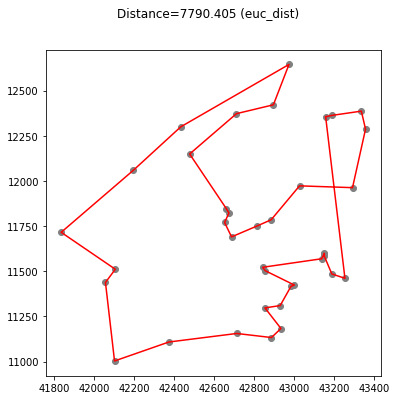

In [185]:
#def random_tour(O):
    #names = O.V
    #return list(np.random.permutation(names))

# Obtener Benchmark
test_file = path.join(benchmark_path,'dj38.tsp')

# Crear Objeto TSP
O = TSPObject(test_file,metrics.euc_dist)

# Crear Matriz de Distancias
O.M()


# Tour Inicial Aleatorio
#tour = O.random_tour()

# Tour Inicial Christofides
#_,tour = tsp_c(O.points)

# Tour Inicial Greedy con Indice Especifico
#tour = TSP_greedy(O,0)

# Tour Inicial Greedy con Indice Aleatorio
tour = TSP_greedy(O,np.random.randint(len(O.V)))

# Tour Inicial Best Greedy
#tour = Best_TSP_greedy(O)


# Algoritmo Hill Climbing
tour = hc_tsp(O,tour)


# Graficar Tour
tspplot.plot_tsp(O,tour,figsize=(6,6))

## Algoritmo Harmony Search

In [6]:
def hs_tsp(O):
    tam = 10
    it = 2000
    for i in range(it):
        
        # 1. Inicializar Harmony Memory (HM)
        HM = []
        for t in range(tam):
            h = random_tour(O)
            d = O.evaluate_tour(h)
            HM.append({'h':h,'d':d})
        HM = sorted(HM, key=lambda k: k['d'])
        
        # 2. Crear Nueva Harmonía
        nh = random_tour(O)
        nd = O.evaluate_tour(nh)
        
        # 3. Actualizar HM
        if nd < HM[-1]['d']:
            HM.append({'h':nh,'d':nd})
            HM = sorted(HM, key=lambda k: k['d'])
            HM.pop()
            
    return HM[0]['h']

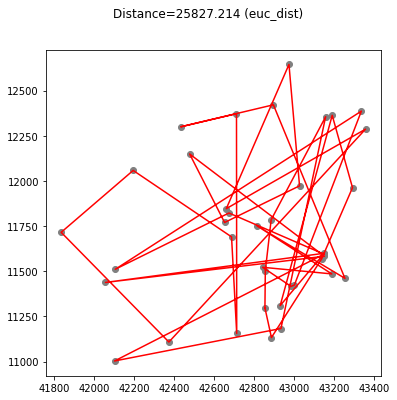

In [191]:
# Algoritmo Harmony Search
tour = hs_tsp(O)


# Graficar Tour
tspplot.plot_tsp(O,tour,figsize=(6,6))

## Algoritmo 2-OPT

In [7]:
def tsp_2opt(O,tour):
    mejor_tour = tour[:]
    mejor_distancia = O.evaluate_tour(mejor_tour)
    mejora = True
    while mejora:
        mejora = False
        for i in range(len(mejor_tour)-1):
            for j in range(i+1,len(mejor_tour)):
                nuevo_tour = swap_2opt(mejor_tour,i,j)
                nueva_distancia = O.evaluate_tour(nuevo_tour)
                if nueva_distancia < mejor_distancia:
                    mejor_distancia = nueva_distancia
                    mejor_tour = nuevo_tour
                    mejora = True
                    break
            if mejora:
                break
    return mejor_tour

def swap_2opt(tour,i,j):
    nuevo_tour = tour[0:i]
    nuevo_tour.extend(reversed(tour[i:j+1]))
    nuevo_tour.extend(tour[j+1:])
    return nuevo_tour

## Algoritmo 3-OPT

In [20]:
def tsp_3opt(O,t):
    tour = t[:]
    delta = 0
    for (a,b,c) in all_segments(len(tour)):
        delta = reverse_if_better(O,tour,a,b,c)
    if delta < 0:
        return tsp_3opt(O,tour)
    return tour

def reverse_if_better(O,tour,i,j,k):
    A,B,C,D,E,F = tour[i-1],tour[i],tour[j-1],tour[j],tour[k-1],tour[k%len(tour)]
    d0 = O._M[A][B] + O._M[C][D] + O._M[E][F]
    d1 = O._M[A][C] + O._M[B][D] + O._M[E][F]
    d2 = O._M[A][B] + O._M[C][E] + O._M[D][F]
    d3 = O._M[F][B] + O._M[C][D] + O._M[E][A]
    d4 = O._M[F][B] + O._M[C][E] + O._M[D][A]
    d5 = O._M[F][C] + O._M[B][D] + O._M[E][A]
    d6 = O._M[A][C] + O._M[B][E] + O._M[D][F]
    d7 = O._M[A][D] + O._M[E][B] + O._M[C][F]
    d = [d0,d1,d2,d3,d4,d5,d6,d7]
    m = np.argmin(d)
    if m == 1:
        tour[i:j] = reversed(tour[i:j])
        return -d0 + d1
    elif m == 2:
        tour[j:k] = reversed(tour[j:k])
        return -d0 + d2
    elif m == 3:
        tour[i:k] = reversed(tour[i:k])
        return -d0 + d3
    elif m == 4:
        tour[j:k] = reversed(tour[j:k])
        tour[i:k] = reversed(tour[i:k])
        return -d0 + d4
    elif m == 5:
        tour[i:j] = reversed(tour[i:j])
        tour[i:k] = reversed(tour[i:k])
        return -d0 + d5
    elif m == 6:
        tour[i:j] = reversed(tour[i:j])
        tour[j:k] = reversed(tour[j:k])
        return -d0 + d6
    elif m == 7:
        tour[i:k] = tour[j:k] + tour[i:j]
        return -d0 + d7
    return d0

def all_segments(N):
    return [(i,j,k)
           for i in range(N)
           for j in range(i+2,N)
           for k in range(j+2,N+(i>0))]

In [9]:
def swap_3opt(O,t,n=[]):
    tour = t[:]
    if n == []:
        i,j,k = random.sample(range(len(tour)), 3)
        i,j,k = sorted([i,j,k])
    else:
        i,j,k = n
    A,B,C,D,E,F = tour[i-1],tour[i],tour[j-1],tour[j],tour[k-1],tour[k%len(tour)]
    d0 = O._M[A][B] + O._M[C][D] + O._M[E][F]
    d1 = O._M[A][C] + O._M[B][D] + O._M[E][F]
    d2 = O._M[A][B] + O._M[C][E] + O._M[D][F]
    d3 = O._M[F][B] + O._M[C][D] + O._M[E][A]
    d4 = O._M[F][B] + O._M[C][E] + O._M[D][A]
    d5 = O._M[F][C] + O._M[B][D] + O._M[E][A]
    d6 = O._M[A][C] + O._M[B][E] + O._M[D][F]
    d7 = O._M[A][D] + O._M[E][B] + O._M[C][F]
    d = [d0,d1,d2,d3,d4,d5,d6,d7]
    # Elegir Mejor Intercambio
    m = np.argmin(d)
    # Intercambio Aleatorio
    #m = np.random.randint(1,len(d))
    if m == 1:
        tour[i:j] = reversed(tour[i:j])
    elif m == 2:
        tour[j:k] = reversed(tour[j:k])
    elif m == 3:
        tour[i:k] = reversed(tour[i:k])
    elif m == 4:
        tour[j:k] = reversed(tour[j:k])
        tour[i:k] = reversed(tour[i:k])
    elif m == 5:
        tour[i:j] = reversed(tour[i:j])
        tour[i:k] = reversed(tour[i:k])
    elif m == 6:
        tour[i:j] = reversed(tour[i:j])
        tour[j:k] = reversed(tour[j:k])
    elif m == 7:
        tour[i:k] = tour[j:k] + tour[i:j]
    return tour

## Solución a TSP


TOUR INICIAL


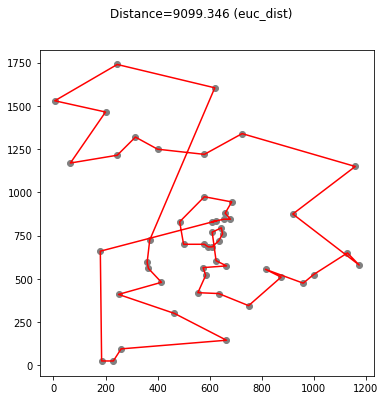

['24', '48', '5', '15', '6', '4', '25', '46', '44', '34', '35', '36', '39', '40', '38', '37', '49', '32', '1', '22', '31', '18', '3', '19', '45', '41', '8', '10', '9', '43', '33', '51', '12', '28', '27', '26', '47', '13', '14', '52', '11', '16', '50', '20', '23', '30', '21', '17', '42', '7', '2', '29']


TOUR FINAL


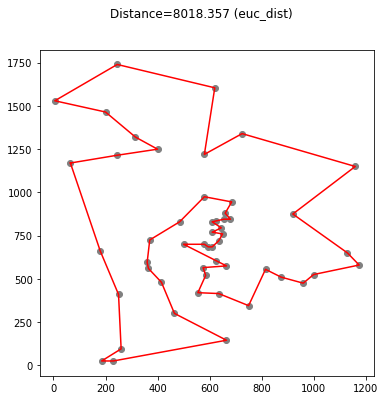

['47', '26', '28', '27', '13', '14', '52', '11', '12', '51', '33', '43', '10', '9', '8', '41', '19', '45', '3', '18', '31', '22', '1', '32', '49', '44', '34', '35', '36', '39', '40', '37', '38', '48', '24', '5', '15', '6', '4', '25', '46', '16', '50', '20', '23', '21', '17', '7', '2', '42', '30', '29']


In [25]:
# Obtener Benchmark
test_file = path.join(benchmark_path,'berlin52.tsp')

# Crear Objeto TSP
O = TSPObject(test_file,metrics.euc_dist)

# Crear Matriz de Distancias
O.M()


# Tour Inicial Aleatorio
#tour = random_tour(O)

# Tour Inicial Christofides
#_,tour = tsp_c(O.points)

# Tour Inicial Greedy con Indice Especifico
#tour = TSP_greedy(O,0)

# Tour Inicial Greedy con Indice Aleatorio
tour = TSP_greedy(O,np.random.randint(len(O.V)))

# Tour Inicial Best Greedy
#tour = Best_TSP_greedy(O)


# Graficar Tour Inicial
print('\nTOUR INICIAL')
tspplot.plot_tsp(O,tour,figsize=(6,6))
print(tour)


# Algoritmo Hill Climbing
#tour = hc_tsp(O,tour)

# Algoritmo 2-OPT
#tour = tsp_2opt(O,tour)

# Algoritmo 3-OPT
tour = tsp_3opt(O,tour)


# Graficar Tour Final
print('\n\nTOUR FINAL')
tspplot.plot_tsp(O,tour,figsize=(6,6))
print(tour)